# Exploratory Data Analytics on [MNIST](https://keras.io/api/datasets/mnist/) Dataset

In [1]:
%matplotlib inline

import numpy as np
from scipy import linalg

from matplotlib import pyplot as plt

from sklearn import model_selection
from sklearn import linear_model
from sklearn import cluster
from sklearn import neighbors
from sklearn import metrics
from sklearn import feature_selection

from keras import datasets

from tqdm.auto import tqdm

### Loading data and checking shapes

In [2]:
(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

11493376/11490434 [==============================] - 2s 0us/step


### Rudimentary Visualization

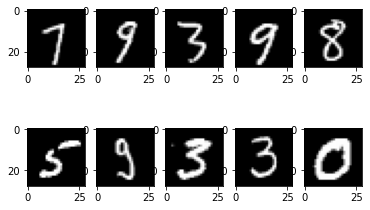

array([[7, 9, 3, 9, 8],
       [5, 9, 3, 3, 0]], dtype=uint8)

In [3]:
SAMPLE = 0
X = 1
Y = 2

def visualize(X, y, n_cols=5, n_rows=None):
    n_rows = n_rows if n_rows else len(y) // n_cols;
    if len(y) > n_rows * n_cols:
        n_rows = n_rows + 1
    _, ax = plt.subplots(n_rows, n_cols)
    if not isinstance(y, np.ndarray):
        _y = np.array(y)
    else:
        _y = y
    if len(y) < n_rows * n_cols:
        _y = np.hstack((_y, np.full((n_rows*n_cols-len(y)), -999)))
    for X_, y_, a in zip(X, y, ax.flatten()):
        a.imshow(X_, cmap=plt.get_cmap('gray'))
    plt.show()
    return _y.reshape(n_rows, n_cols)

visualize(x_train[42:52], y_train[42:52])

### Flattening

In [4]:
def flatten(X_):
    return X_.reshape((-1, X_.shape[X] * X_.shape[Y]))

tr_x_flat = flatten(x_train)
ts_x_flat = flatten(x_test)

### Feature Selection by ANOVA

In [5]:
selector = feature_selection.SelectKBest(score_func=feature_selection.f_classif, k="all")
selector.fit(tr_x_flat, y_train)

/opt/conda/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  0   1   2   3   4   5   6   7   8   9  10  11  16  17  18  19  20  21
  22  23  24  25  26  27  28  29  30  31  52  53  54  55  56  57  82  83
  84  85 111 112 140 141 168 476 560 644 645 671 672 673 699 700 701 727
 728 729 730 754 755 756 757 758 759 780 781 782 783] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/opt/conda/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


SelectKBest(k='all')

In [6]:
NUM_ANOVA_FEATURES = 400
valid_features_anova = selector.pvalues_ < 0.05
print ("number of valid ANOVA features with p-values < 0.05 : {}".format(np.count_nonzero(valid_features_anova)))

f_scores = selector.scores_.copy()
f_scores[~valid_features_anova] = -np.inf

valid_features_anova_top_100 = np.flip(np.argsort(f_scores))[:NUM_ANOVA_FEATURES]
valid_features_anova_top_100[:10]

number of valid ANOVA features with p-values < 0.05 : 668


array([350, 378, 406, 461, 434, 542, 409, 514, 433, 386])

### Rudimentary SVD

In [7]:
U, s, Vt = linalg.svd(tr_x_flat)

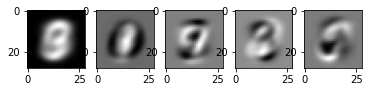

array([[-9, -9, -9, -9, -9]])

In [8]:
visualize(Vt[0:5].reshape(-1, 28, 28), y=[-9] * 5)

In [10]:
NUM_SVD_FEATURES = 10
V_ = Vt[0:NUM_SVD_FEATURES].T
V_.shape

(784, 10)

In [11]:
def get_svd_features(X_, V_):
    return X_ @ V_

tr_x_svd_features = get_svd_features(tr_x_flat, V_)
ts_x_svd_features = get_svd_features(ts_x_flat, V_)

### Per Label SVD

  0%|          | 0/10 [00:00<?, ?it/s]

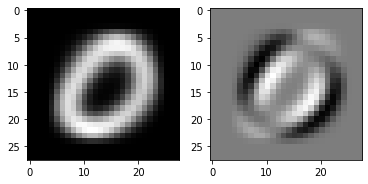

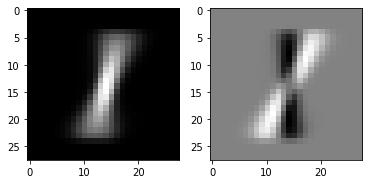

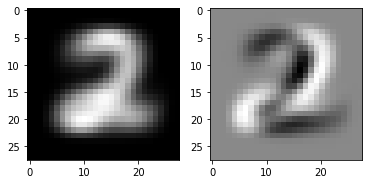

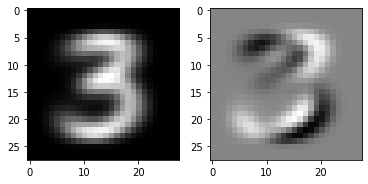

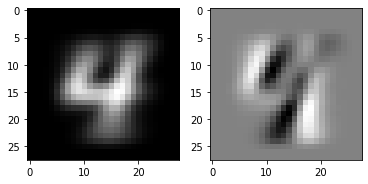

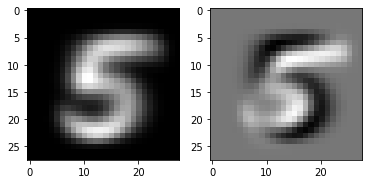

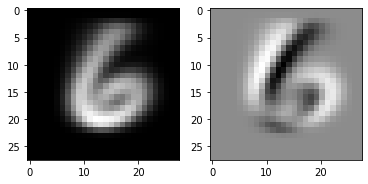

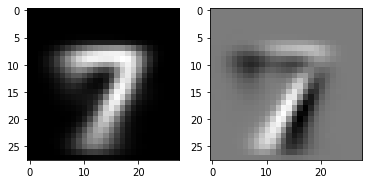

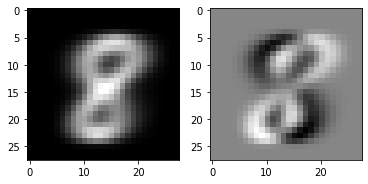

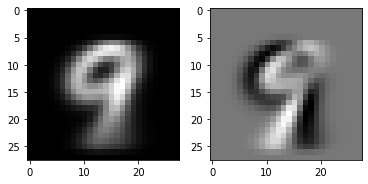

In [12]:
def per_label_svd(X_, y_, y_label):
    selector = y_ == y_label
    U, s, Vt = linalg.svd(X_[selector])
    return Vt

NUM_PER_LABEL_SVD_FEATURES = 2
NUM_LABELS = 10
pbar = tqdm(range(0, NUM_LABELS))
per_label_V = {}
for y_label in pbar:
    pbar.set_description("working on label : {}".format(y_label))
    Vt_ = per_label_svd(tr_x_flat, y_train, y_label=y_label)
    visualize(Vt_[0:NUM_PER_LABEL_SVD_FEATURES].reshape(-1, 28, 28), y=[y_label] * NUM_PER_LABEL_SVD_FEATURES, n_cols=NUM_PER_LABEL_SVD_FEATURES)
    per_label_V[y_label] = Vt_[0:NUM_PER_LABEL_SVD_FEATURES].T

In [14]:
def get_per_label_svd_features(X_, per_label_V_):
    result_X_ = []
    for y_label, pl_V_ in tqdm(per_label_V_.items()):
        per_label_X_ = X_ @ pl_V_
        result_X_.append(per_label_X_)
    return np.hstack(tuple(result_X_))

tr_x_per_label_svd_features = get_per_label_svd_features(tr_x_flat, per_label_V)
ts_x_per_label_svd_features = get_per_label_svd_features(ts_x_flat, per_label_V)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

### Trying `LogisticRegression`

In [15]:
logit_model = linear_model.LogisticRegression(
    penalty="elasticnet",
    C=1.0/500,
    l1_ratio=0.25,
    solver="saga",
    multi_class="ovr",
    max_iter=500,
    n_jobs=2,
    verbose=1
)
logit_model.fit(tr_x_flat[:,valid_features_anova_top_100], y_train)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


max_iter reached after 247 seconds


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 249 seconds


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 252 seconds


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 257 seconds


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 245 seconds
max_iter reached after 238 seconds


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 207 seconds


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 209 seconds


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 278 seconds


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 286 seconds


[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed: 20.6min finished


LogisticRegression(C=0.002, l1_ratio=0.25, max_iter=500, multi_class='ovr',
                   n_jobs=2, penalty='elasticnet', solver='saga', verbose=1)

In [16]:
y_pred_logit = logit_model.predict(ts_x_flat[:, valid_features_anova_top_100])

print (metrics.classification_report(y_test, y_pred_logit))

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       980
           1       0.96      0.98      0.97      1135
           2       0.93      0.88      0.90      1032
           3       0.90      0.91      0.90      1010
           4       0.92      0.92      0.92       982
           5       0.91      0.85      0.88       892
           6       0.94      0.95      0.94       958
           7       0.93      0.92      0.93      1028
           8       0.84      0.88      0.86       974
           9       0.89      0.89      0.89      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



In [17]:
tr_x_all_svd_features = np.hstack((tr_x_svd_features, tr_x_per_label_svd_features))
logit_svd_model = linear_model.LogisticRegression(
    penalty="elasticnet",
    C=1.0/500,
    l1_ratio=0.25,
    solver="saga",
    multi_class="ovr",
    max_iter=500,
    n_jobs=2,
    verbose=1
)
logit_svd_model.fit(tr_x_all_svd_features, y_train)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


convergence after 260 epochs took 11 seconds
convergence after 363 epochs took 16 seconds
convergence after 243 epochs took 10 seconds
convergence after 500 epochs took 20 seconds
max_iter reached after 20 seconds


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


convergence after 244 epochs took 10 seconds
convergence after 221 epochs took 9 seconds
convergence after 433 epochs took 18 seconds
max_iter reached after 21 seconds


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


convergence after 282 epochs took 11 seconds
convergence after 341 epochs took 14 seconds


[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:  1.2min finished


LogisticRegression(C=0.002, l1_ratio=0.25, max_iter=500, multi_class='ovr',
                   n_jobs=2, penalty='elasticnet', solver='saga', verbose=1)

In [18]:
ts_x_all_svd_features = np.hstack((ts_x_svd_features, ts_x_per_label_svd_features))
y_pred_logit_svd = logit_svd_model.predict(ts_x_all_svd_features)

print (metrics.classification_report(y_test, y_pred_logit))

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       980
           1       0.96      0.98      0.97      1135
           2       0.93      0.88      0.90      1032
           3       0.90      0.91      0.90      1010
           4       0.92      0.92      0.92       982
           5       0.91      0.85      0.88       892
           6       0.94      0.95      0.94       958
           7       0.93      0.92      0.93      1028
           8       0.84      0.88      0.86       974
           9       0.89      0.89      0.89      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



### Trying `KNeighborsClassifier`

In [19]:
knn_model = neighbors.KNeighborsClassifier()
knn_model.fit(tr_x_svd_features, y_train)
y_pred_knn = knn_model.predict(ts_x_svd_features)

print (metrics.classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       980
           1       0.97      0.99      0.98      1135
           2       0.94      0.95      0.94      1032
           3       0.91      0.90      0.91      1010
           4       0.91      0.90      0.90       982
           5       0.91      0.92      0.92       892
           6       0.96      0.96      0.96       958
           7       0.95      0.92      0.94      1028
           8       0.90      0.88      0.89       974
           9       0.86      0.88      0.87      1009

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



In [20]:
knn_model_2 = neighbors.KNeighborsClassifier()
knn_model_2.fit(tr_x_per_label_svd_features, y_train)
y_pred_knn_2 = knn_model_2.predict(ts_x_per_label_svd_features)

print (metrics.classification_report(y_test, y_pred_knn_2))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       980
           1       0.97      0.99      0.98      1135
           2       0.95      0.94      0.95      1032
           3       0.91      0.90      0.91      1010
           4       0.92      0.89      0.91       982
           5       0.92      0.90      0.91       892
           6       0.95      0.96      0.96       958
           7       0.95      0.90      0.92      1028
           8       0.89      0.88      0.88       974
           9       0.84      0.90      0.87      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



### Let's Keep Copies of the Objects

In [24]:
import pickle

# this is Domino specific, which is not recommended.
with open ("/mnt/V_.bin", "wb") as f:
    pickle.dump(V_, f, protocol=pickle.HIGHEST_PROTOCOL)
    
with open ("/mnt/per_label_V.bin", "wb") as f:
    pickle.dump(per_label_V, f, protocol=pickle.HIGHEST_PROTOCOL)
    
with open ("/mnt/SelectKBest.bin", "wb") as f:
    pickle.dump(selector, f, protocol=pickle.HIGHEST_PROTOCOL)
    
with open ("/mnt/valid_features_anova_top_100.bin", "wb") as f:
    pickle.dump(valid_features_anova_top_100, f, protocol=pickle.HIGHEST_PROTOCOL)

### Bagging of All

Since this is just an example, I am going to conclude the EDA by deciding to apply **bagging** and **stacking** to `LogisticRegression` and `KNeighborsClassifier`. 

In [36]:
from sklearn import ensemble
X_train_bagging = np.hstack((tr_x_flat[:, valid_features_anova_top_100], tr_x_all_svd_features))
model_bag_1 = ensemble.BaggingClassifier(
    base_estimator=linear_model.LogisticRegression(
        penalty="elasticnet", C=1.0/500, l1_ratio=0.25,
        solver="saga", multi_class="ovr", max_iter=300
    ), 
    max_samples=0.8,
    max_features=35,
    n_jobs=1,
    random_state=42,
    verbose=1
)
model_bag_2 = ensemble.BaggingClassifier(
    base_estimator=neighbors.KNeighborsClassifier(),
    n_estimators=20,
    max_samples=0.8,
    max_features=20,
    n_jobs=1,
    random_state=42,
    verbose=1
)
final_model = ensemble.StackingClassifier(
    estimators=[
        ("logits", model_bag_1),
        ("knns", model_bag_2)
    ],
    n_jobs=1
)

In [ ]:
final_model.fit(X_train_bagging, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
